# <b><u> Project Title : Extraction/identification of major topics & themes discussed in news articles. </u></b>

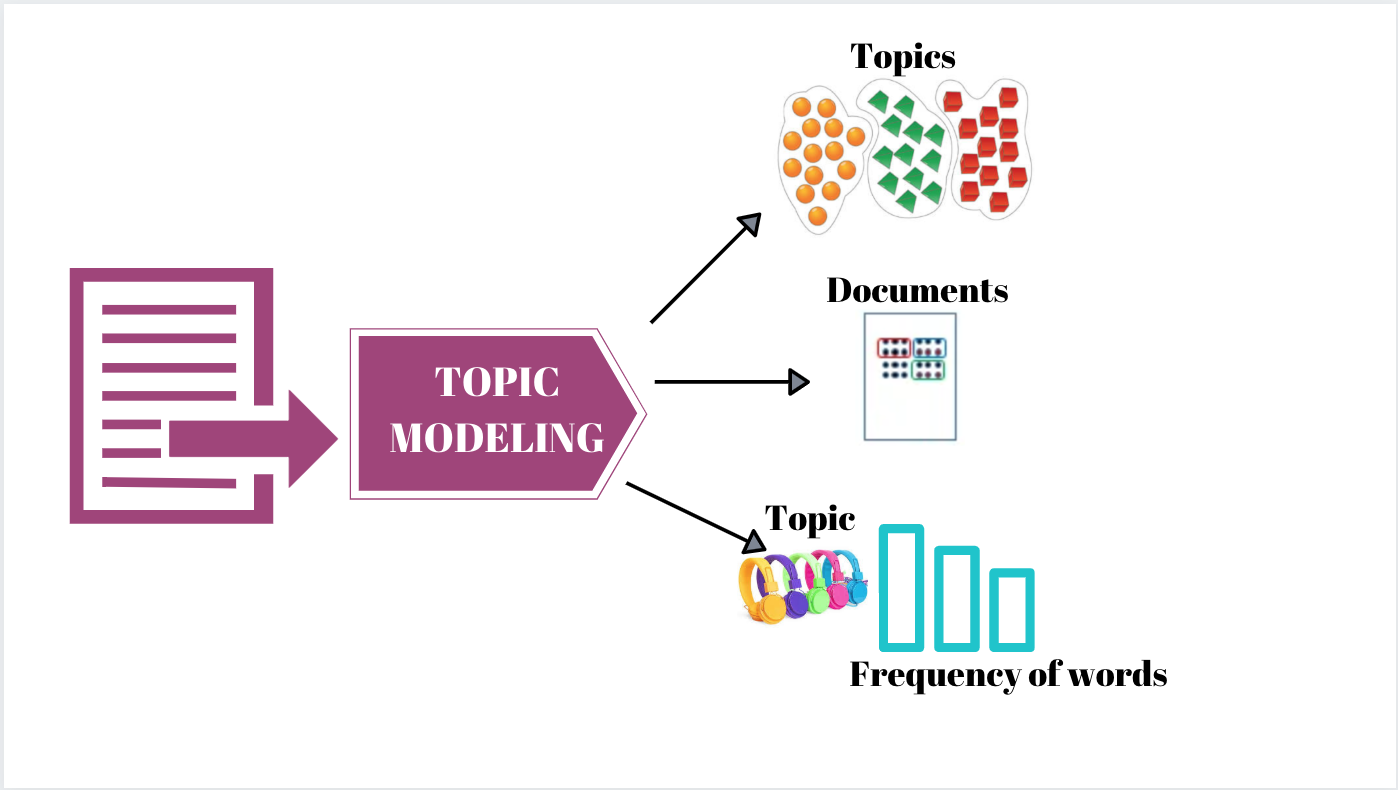

## <b> Problem Description </b>

### In this project your task is to identify major themes/topics across a collection of BBC news articles. You can use clustering algorithms such as Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA) etc.

## <b> Data Description </b>

### The dataset contains a set of news articles for each major segment consisting of business, entertainment, politics, sports and technology. You need to create an aggregate dataset of all the news articles and perform topic modeling on this dataset. Verify whether these topics correspond to the different tags available.

The problem that we would like to talk about here is to find the best segregation of documents according to their topics. This kind of separation can be used for assigning a topic to a document (which is called topic labeling) or for general determination of compressed characteristics of a huge text data set.

# **Mounting Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing The Modules**

In [2]:
import pandas as pd
import numpy as np
import string
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import gensim.corpora as corpora
from collections import Counter
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import spacy
nltk.download('stopwords')
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
pip install autocorrect


     |████████████████████████████████| 622 kB 26.0 MB/s 
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622382 sha256=557ec47128009d04ee77910978fcef2186418fcb6437b94aa422c8776532d418
  Stored in directory: /root/.cache/pip/wheels/54/d4/37/8244101ad50b0f7d9bffd93ce58ed7991ee1753b290923934b
Successfully built autocorrect


In [4]:
!pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 27.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=8584bfd64be8d890c483ec1e4282e87e4a69e3be16ce8d7d46299f8ad3fee3bd
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


**First we have to develop our own dataset for our dataset, we will read all the downloaded articles into one list corpus. We will use the folder name as a list of labels.Then we can covert them into dataframe**

In [5]:
News=[]
Type=[]

path="/content/drive/MyDrive/Colab Notebooks/1news topic modeling project/bbc"
folders=["business","entertainment","politics","sport","tech"] 
for i in folders:
    files=os.listdir(path+'/'+i)
    for text_file in files:
        file_path=path + '/'+i+'/'+text_file
        with open(file_path,'rb') as f:
            data=f.read()
        News.append(data)
        Type.append(i)
      

data={'news':News,'type':Type}
df = pd.DataFrame(data)

**Basic Operation**

In [6]:
df.head()

news      type
0  b'Yukos unit buyer faces loan claim\n\nThe own...  business
1  b'Ad sales boost Time Warner profit\n\nQuarter...  business
2  b'Dollar gains on Greenspan speech\n\nThe doll...  business
3  b'US trade gap hits record in 2004\n\nThe gap ...  business
4  b'High fuel prices hit BA\'s profits\n\nBritis...  business

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   news    2225 non-null   object
 1   type    2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [8]:
# removing duplicate observations
df=df.drop_duplicates()

In [9]:
df.type.value_counts()

sport            505
business         503
politics         403
entertainment    369
tech             347
Name: type, dtype: int64

In [10]:
df.type.value_counts(normalize=True)*100

sport            23.742360
business         23.648331
politics         18.946874
entertainment    17.348378
tech             16.314057
Name: type, dtype: float64

# **Text Preprocessing**

In [11]:
# Converting column into astring
df['news'] = df['news'].astype('str') 

In [12]:
# Removing HTML Tag
import re
def remove_html_tags(text):
	html_pattern = r'<.*?>'
	without_html = re.sub(pattern=html_pattern, repl=' ', string=text)
	return without_html

In [13]:
df['news']=df['news'].apply(remove_html_tags)

In [14]:
# Removing URLs
def remove_urls(text):
	url_pattern = r'https?://\S+|www\.\S+' 
	without_urls = re.sub(pattern=url_pattern, repl=' ', string=text)
	return without_urls

In [15]:
df['news']=df['news'].apply(remove_urls)

In [16]:
# Removing numbers
def remove_numbers(text):
	number_pattern = r'\d+'
	without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
	return without_number

In [17]:
df['news']=df['news'].apply(remove_numbers)

In [18]:
# Removing single Charecter
def remove_single_char(text):
	single_char_pattern = r'\s+[a-zA-Z]\s+'
	without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
	return without_sc

In [19]:
df['news']=df['news'].apply(remove_single_char)

In [28]:
stop_list=list(stopwords.words('english'))
stop_list.append('would')
stop_list.append('could')
stop_list.append('say')

In [30]:
# Removing StopWord
def Change_text(msg):
  punc=[char for char in msg if str(char) not in string.punctuation]
  no_punc=''.join(punc)
  main_text=[word for word in no_punc.split() if word.lower() not in stop_list]
  return ' '.join(main_text)

In [31]:
# Doing Lemmatization
def lemmatization(texts):
  sentence=''
  allowed_postags=['NOUN','ADJ','VERB','ADV']
  texts_out=[]
  doc=nlp(texts)
  texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
  return ' '.join(texts_out[0])

In [32]:
df['news']=df['news'].apply(Change_text)

In [24]:
nlp=spacy.load('en',disable=['parser', 'ner'])
df['news']=df['news'].apply(lemmatization)

In [33]:
df.news[0]

'unit buyer face loan owner embattle russian oil giant ask buyer former production unit pay loannnstateowne buy unit bn sale force part settle bn tax claim owner ask repay loan secured asset already face similar repayment demand foreign bank legal expert purchase include obligation pledge asset pay real money creditor avoid seizure yugansk asset moscowbase lawyer connect case manage director tell news agency default fight rule law exist international arbitration clause official unavailable comment company intend take action recover tax claim debt owe file bankruptcy protection court attempt prevent force sale main production arm sale go ahead sell littleknown shell company turn buy claim downfall punishment political ambition founder vow participant salen'

# **The EDA**

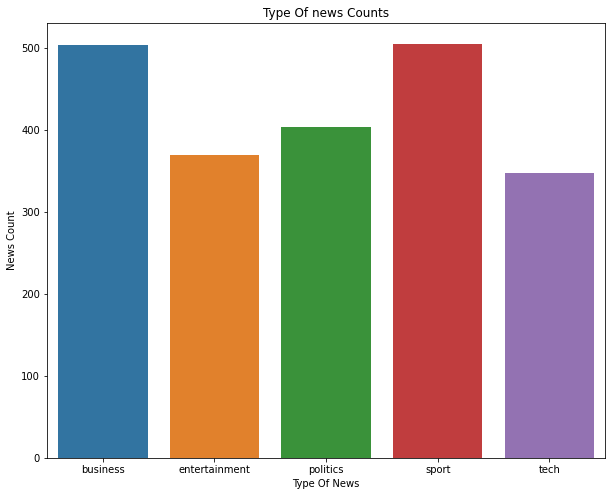

In [34]:
import warnings 
plt.figure(figsize=(10,8))
warnings.filterwarnings("ignore")
sns.countplot(df['type'], data=df)
plt.xlabel("Type Of News")
plt.ylabel("News Count")
plt.title("Type Of news Counts")
plt.show()

In [35]:
df['length']=df['news'].apply(len)
df.head()

news      type  length
0  unit buyer face loan owner embattle russian oi...  business     764
1  bad sale boost profitnnquarterly profit medium...  business    1311
2  gain dollar hit high level almost month head t...  business    1178
3  trade gap hit record nnthe gap export import h...  business    1060
4  bhigh fuel price hit ba profitsnnbritish blame...  business    1242

In [36]:
df['word_count'] = df['news'].apply(lambda x: len(str(x).split(" ")))
df.head()

news  ... word_count
0  unit buyer face loan owner embattle russian oi...  ...        112
1  bad sale boost profitnnquarterly profit medium...  ...        181
2  gain dollar hit high level almost month head t...  ...        169
3  trade gap hit record nnthe gap export import h...  ...        154
4  bhigh fuel price hit ba profitsnnbritish blame...  ...        176

[5 rows x 4 columns]

In [37]:
df_Business = df[df['type'] == 'business']
df_Entertainment = df[df['type'] == 'entertainment']
df_Politics = df[df['type'] == 'politics']
df_Sport = df[df['type'] == 'sport']
df_Tech = df[df['type'] == 'tech']

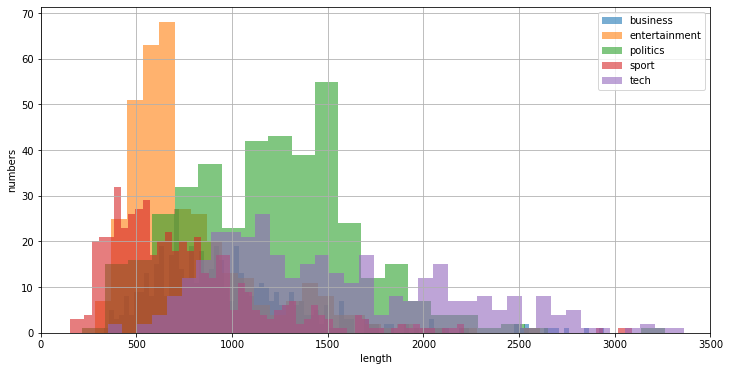

In [38]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
bins = 100
plt.hist(df_Business['length'], alpha = 0.6, bins=bins, label='business')
plt.hist(df_Entertainment['length'], alpha = 0.6, bins=bins, label='entertainment')
plt.hist(df_Politics['length'], alpha = 0.6, bins=bins, label='politics')
plt.hist(df_Sport['length'], alpha = 0.6, bins=bins, label='sport')
plt.hist(df_Tech['length'], alpha = 0.6, bins=bins, label='tech')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,3500)
plt.grid()
plt.show()

Length of all type of topics are dense between 300-2000 so couldn't distinguish between topic with help of word length. 

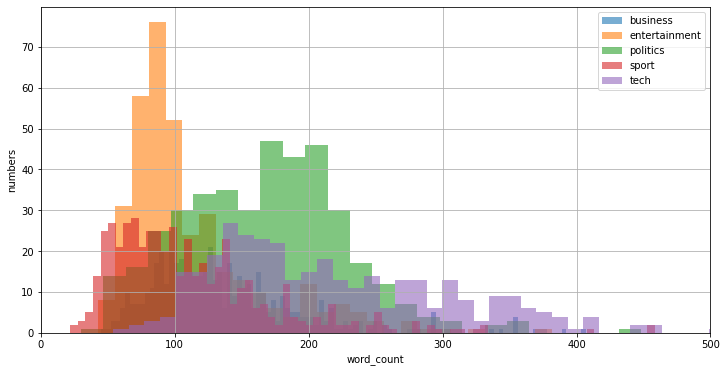

In [39]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
bins = 100
plt.hist(df_Business['word_count'], alpha = 0.6, bins=bins, label='business')
plt.hist(df_Entertainment['word_count'], alpha = 0.6, bins=bins, label='entertainment')
plt.hist(df_Politics['word_count'], alpha = 0.6, bins=bins, label='politics')
plt.hist(df_Sport['word_count'], alpha = 0.6, bins=bins, label='sport')
plt.hist(df_Tech['word_count'], alpha = 0.6, bins=bins, label='tech')
plt.xlabel('word_count')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,500)
plt.grid()
plt.show()

It's similar to length which is prittey obvious.

## First we develop a list of the top words used across all headlines, giving us a glimpse into the core vocabulary of the source data. Stop words are omitted here to avoid any trivial conjunctions, prepositions, etc.

In [40]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

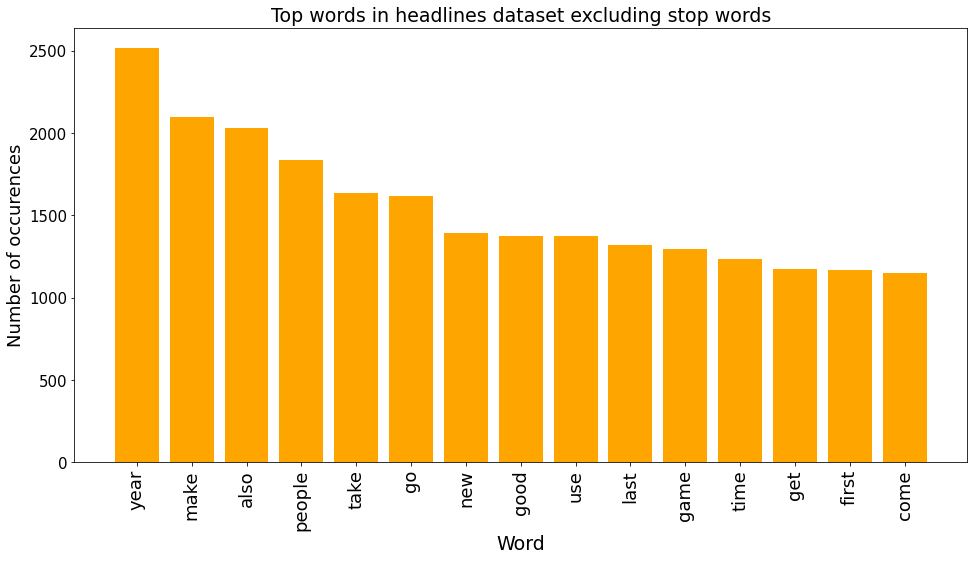

In [48]:
count_vectorizer = CountVectorizer()
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df['news'])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values, color = "orange")
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation='vertical')
ax.set_title('Top words in headlines dataset excluding stop words',fontsize=19)
ax.set_xlabel('Word',fontsize=19)
plt.yticks(fontsize=15)
plt.xticks(fontsize=18)
ax.set_ylabel('Number of occurences',fontsize=18)
plt.show()

We could see that our top word are in our dataset are year,make

**WordcCloud for Topic Business**

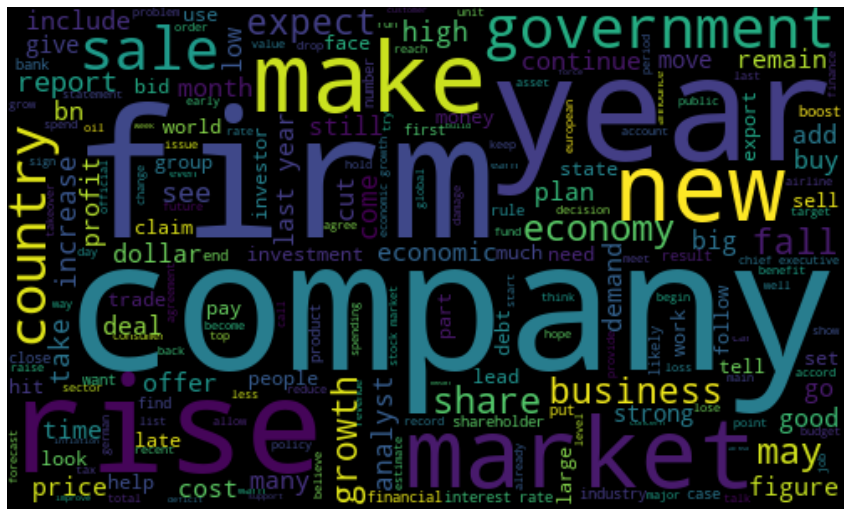

In [ ]:
plt.figure(figsize=(15,10))
allWords = ' '.join([topic for topic in df[df['type']=='business']['news']])
wordCloud = WordCloud(width=500, height=300, background_color="black", random_state=21, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**WordCloud For Topic Tech**

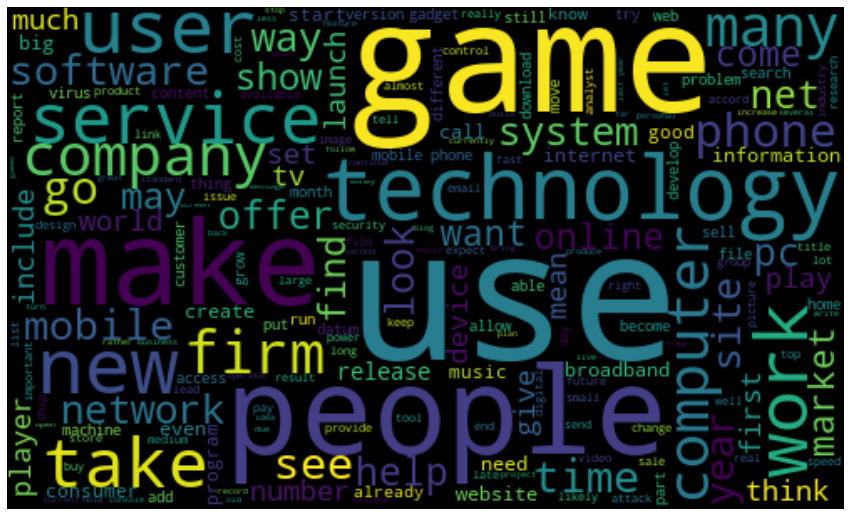

In [ ]:
plt.figure(figsize=(15,10))
allWords = ' '.join([topic for topic in df[df['type']=='tech']['news']])
wordCloud = WordCloud(width=500, height=300, background_color="black", random_state=21, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**WordCloud For Topic sport**

In [ ]:
plt.figure(figsize=(15,10))
allWords = ' '.join([topic for topic in df[df['type']=='sport']['news']])
wordCloud = WordCloud(width=500, height=300, background_color="black", random_state=21, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
plt.figure(figsize=(15,10))
allWords = ' '.join([topic for topic in df[df['type']=='entertainment']['news']])
wordCloud = WordCloud(width=500, height=300, background_color="black", random_state=21, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

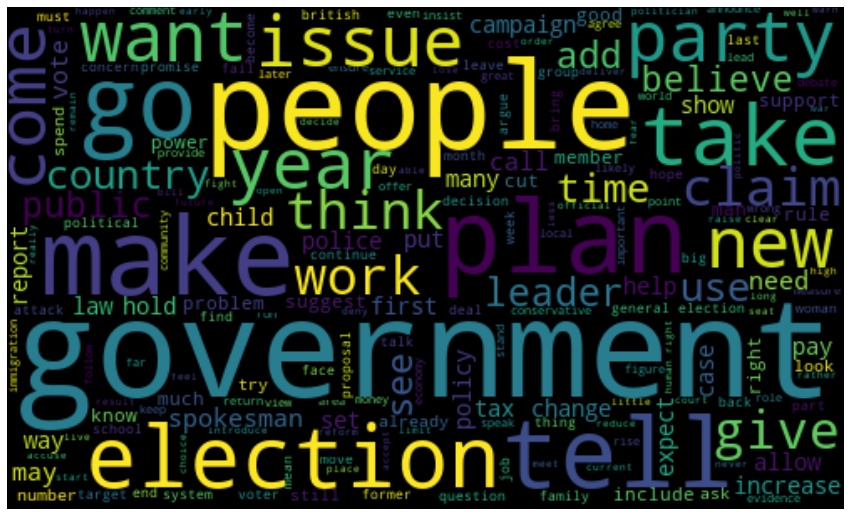

In [ ]:
plt.figure(figsize=(15,10))
allWords = ' '.join([topic for topic in df[df['type']=='politics']['news']])
wordCloud = WordCloud(width=500, height=300, background_color="black", random_state=21, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# **Topic Modelling**

We now apply a clustering algorithm to the headlines corpus in order to study the topic focus of BBC News. 

TF-IDF Vectorizer with unigram

In [ ]:
vectorizer = TfidfVectorizer(max_df=0.8, max_features=8000,min_df=0.05)

In [ ]:
matrix=vectorizer.fit_transform(df['news'])

In [ ]:
df1 = pd.DataFrame(matrix.todense() , columns=vectorizer.get_feature_names())

In [ ]:
df1.head()

able  accept  access  accord   account  ...  write      year  yearold  yet  young
0   0.0     0.0     0.0     0.0  0.000000  ...    0.0  0.000000      0.0  0.0    0.0
1   0.0     0.0     0.0     0.0  0.193046  ...    0.0  0.000000      0.0  0.0    0.0
2   0.0     0.0     0.0     0.0  0.290557  ...    0.0  0.039497      0.0  0.0    0.0
3   0.0     0.0     0.0     0.0  0.000000  ...    0.0  0.118863      0.0  0.0    0.0
4   0.0     0.0     0.0     0.0  0.000000  ...    0.0  0.163999      0.0  0.0    0.0

[5 rows x 456 columns]

# **Latent Semantic Analysis**

In [ ]:
lsa_model = TruncatedSVD(n_components=5)
lsa_topic_matrix = lsa_model.fit_transform(matrix)

In [ ]:
lsa_topic_dist = pd.DataFrame(lsa_model.transform(matrix))
lsa_topic_dist.to_csv('lsa.csv', index=False)
lsa_doc=pd.read_csv("lsa.csv")

In [ ]:
lsa_doc.columns=['topic1','topic2','topic3','topic4','topic5']

In [ ]:
sns.heatmap(data=lsa_doc.corr(),annot=True,cmap='coolwarm')

In [ ]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [ ]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

However, these topic categories are in and of themselves a little meaningless. In order to better characterise them, it will be helpful to find the most frequent words in each.

In [ ]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(lsa_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0],end=" ")
        

Topic 0: 
year make also game people go take Topic 1: 
game play win good player film match Topic 2: 
film award include good director star movie Topic 3: 
sale rise price growth market fall year Topic 4: 
phone use mobile game technology user firm 

Thus we have converted our initial small sample of headlines into a list of predicted topic categories, where each category is characterised by its most frequent words. The relative magnitudes of each of these categories can then be easily visualised though use of a bar chart.

In [ ]:
# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(5):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [ ]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2127 samples in 0.004s...
[t-SNE] Computed neighbors for 2127 samples in 0.097s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2127
[t-SNE] Computed conditional probabilities for sample 2000 / 2127
[t-SNE] Computed conditional probabilities for sample 2127 / 2127
[t-SNE] Mean sigma: 0.057014
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.039764
[t-SNE] KL divergence after 2000 iterations: 0.850639


Now that we have reduced these n_topics-dimensional vectors to two-dimensional representations, we can then plot the clusters using Bokeh. Before doing so however, it will be useful to derive the centroid location of each topic, so as to better contextualise our visualisation.

In [ ]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:5]

In [ ]:
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(5):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [ ]:
df['target'] = pd.factorize(df['type'])[0] + 1

In [ ]:

!pip install umap-learn

     |████████████████████████████████| 86 kB 3.5 MB/s 
     |████████████████████████████████| 1.1 MB 19.6 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=155b1ab5d6944bfd1d38b62e2c1b693baea8808674c16cd15a961589913ed7ed
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=83a89158748a00bee0aebec2c76fee9ebbebc7dbff7fbbd3b79ebb1f0edc01a1
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


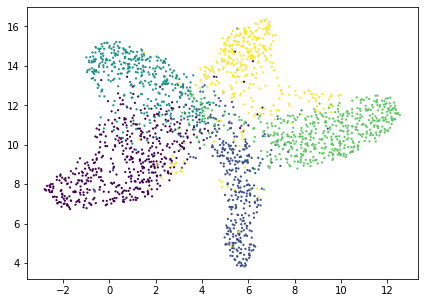

In [ ]:
import umap.umap_ as umap

X_topics = lsa_model.fit_transform(matrix)
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics)

plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], c = df.target,s = 5,edgecolor='none')
plt.show()


In [ ]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, matrix, vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(5), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(5):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)

# **Latent Dirichilet Allocation(Using Gensim)**

In [ ]:
word_data=df['news'].str.split().tolist()

In [ ]:
id2word=corpora.Dictionary(word_data)
corpus=[id2word.doc2bow(text) for text in word_data]

In [ ]:
print(corpus[:120])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 3), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 3), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 2), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 2), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 2), (52, 1), (53, 2), (54, 1), (55, 1), (56, 2), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 3), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 2), (73, 1), (74, 1), (75, 1), (76, 3), (77, 1)], [(3, 1), (19, 2), (26, 1), (34, 1), (37, 1), (41, 1), (53, 1), (58, 1), (64, 5), (69, 1), (78, 2), (79, 1), (80, 1), (81, 1), (82, 1), (83, 2), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 2), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 2), (100, 2), (101, 1

In [ ]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('action', 1),
  ('agency', 1),
  ('ahead', 1),
  ('already', 1),
  ('ambition', 1),
  ('arbitration', 1),
  ('arm', 1),
  ('ask', 2),
  ('asset', 3),
  ('avoid', 1),
  ('bank', 1),
  ('bankruptcy', 1),
  ('bn', 1),
  ('buy', 1),
  ('buyer', 1),
  ('case', 1),
  ('claim', 3),
  ('clause', 1),
  ('comment', 1),
  ('company', 2),
  ('creditor', 1),
  ('debt', 1),
  ('default', 1),
  ('demand', 1),
  ('director', 1),
  ('embattle', 1),
  ('exist', 1),
  ('expert', 1),
  ('face', 2),
  ('fight', 1),
  ('file', 1),
  ('foreign', 1),
  ('former', 1),
  ('founder', 1),
  ('giant', 1),
  ('go', 1),
  ('include', 1),
  ('intend', 1),
  ('international', 1),
  ('law', 1),
  ('lawyer', 1),
  ('legal', 1),
  ('loan', 2),
  ('main', 1),
  ('manage', 1),
  ('money', 1),
  ('news', 1),
  ('obligation', 1),
  ('official', 1),
  ('oil', 1),
  ('owe', 1),
  ('owner', 2),
  ('part', 1),
  ('pay', 2),
  ('pledge', 1),
  ('political', 1),
  ('production', 2),
  ('punishment', 1),
  ('purchase', 1),
  ('r

In [ ]:
import gensim

In [ ]:
lda_model= gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=5,update_every=1)

In [ ]:
# import pyLDAvis.gensim

In [ ]:
!pip install pyLDAvis

In [ ]:
import pyLDAvis

In [ ]:
import pyLDAvis.gensim_models as gensimvis

In [ ]:
pyLDAvis.enable_notebook()
vis=gensimvis.prepare(lda_model,corpus,id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.020357  0.043627       1        1  33.694426
0      0.079258 -0.008752       2        1  29.979522
4      0.006062 -0.025723       3        1  16.107529
1     -0.072083  0.008989       4        1  10.821773
2     -0.033593 -0.018141       5        1   9.396750, topic_info=        Term         Freq        Total Category  logprob  loglift
683     game  2575.000000  2575.000000  Default  30.0000  30.0000
598      use  1935.000000  1935.000000  Default  29.0000  29.0000
580   people  1771.000000  1771.000000  Default  28.0000  28.0000
1267   phone   915.000000   915.000000  Default  27.0000  27.0000
440   mobile   880.000000   880.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
530   become    81.734676   479.413886   Topic5  -5.7930   0.5957
965     play   109.988598  1218.513455   Topic5  -5.4961  -0.0402
323      new   118.690741  1685.147265   Topic5  -5.4199  -0.2883
83      also   116.724796  1917.372506   Topic5  -5.4367  -0.4341
113     firm    93.531277  1111.344502   Topic5  -5.6582  -0.1102

[444 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
13934      2  0.271868       RFID
13934      5  0.543737       RFID
15305      2  0.287473     TVnnWe
15305      5  0.574946     TVnnWe
7806       1  0.267907  according
...      ...       ...        ...
279        1  0.383149       year
279        2  0.318199       year
279        3  0.129354       year
279        4  0.071499       year
279        5  0.098243       year

[1249 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 5, 2, 3])

# **Latent Dirichilet Allocation**

In [ ]:
model=LatentDirichletAllocation(n_components=5)
lda_topic_matrix=model.fit_transform(matrix)

In [ ]:
doc_topic_dist = pd.DataFrame(model.transform(matrix))
doc_topic_dist.to_csv('doc_topic_dist.csv', index=False)
doc=pd.read_csv("doc_topic_dist.csv")

In [ ]:
doc.columns=['topic1','topic2','topic3','topic4','topic5']

In [ ]:
doc

topic1    topic2    topic3    topic4    topic5
0     0.029415  0.028987  0.029613  0.882475  0.029510
1     0.026727  0.026234  0.161910  0.741884  0.043245
2     0.025160  0.024681  0.025185  0.900002  0.024973
3     0.028380  0.027817  0.028417  0.886714  0.028672
4     0.026817  0.026135  0.026621  0.893941  0.026486
...        ...       ...       ...       ...       ...
2122  0.033335  0.032861  0.866931  0.033707  0.033165
2123  0.027032  0.025834  0.893453  0.026848  0.026833
2124  0.026444  0.025674  0.894835  0.026670  0.026378
2125  0.027523  0.027113  0.889655  0.027788  0.027921
2126  0.031265  0.030690  0.875595  0.031402  0.031048

[2127 rows x 5 columns]

In [ ]:
sns.heatmap(data=doc.corr(),annot=True,cmap='coolwarm')

In [ ]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [ ]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2127 samples in 0.012s...
[t-SNE] Computed neighbors for 2127 samples in 0.180s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2127
[t-SNE] Computed conditional probabilities for sample 2000 / 2127
[t-SNE] Computed conditional probabilities for sample 2127 / 2127
[t-SNE] Mean sigma: 0.003394
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.343361
[t-SNE] KL divergence after 2000 iterations: 0.207683


In [ ]:
top_3_words_lda = get_top_n_words(3, lda_keys, matrix,vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(5), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(5):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

In [ ]:
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

In [ ]:
lda_panel = pyLDAvis.sklearn.prepare(model,matrix,vectorizer,mds='tsne')
lda_panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3      150.222153  -72.269554       1        1  27.228264
0       51.163364 -159.968018       2        1  23.341739
1      -73.144554   21.523815       3        1  22.063615
4      -66.410133 -110.606438       4        1  16.923492
2       54.417324   12.443444       5        1  10.442890, topic_info=        Term       Freq      Total Category  logprob  loglift
158     film  80.000000  80.000000  Default  30.0000  30.0000
34     award  44.000000  44.000000  Default  29.0000  29.0000
419     star  46.000000  46.000000  Default  28.0000  28.0000
177     game  76.000000  76.000000  Default  27.0000  27.0000
286    music  42.000000  42.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
19      also  15.629178  83.270408   Topic5  -4.4368   0.5863
323     play  13.309084  70.386788   Topic5  -4.5975   0.5937
56   british   9.934297  30.943855   Topic5  -4.8899   1.1231
163    first  12.026444  63.814560   Topic5  -4.6988   0.5904
435     take  12.187780  74.629034   Topic5  -4.6855   0.4472

[244 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2         1  0.226397   access
2         3  0.113198   access
2         4  0.622591   access
5         1  0.755558   accuse
5         2  0.058120   accuse
...     ...       ...      ...
480       4  0.099651     year
480       5  0.189337     year
481       1  0.174444  yearold
481       2  0.627998  yearold
481       5  0.174444  yearold

[735 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 5, 3])

###This is a much better result! Controlling for  t -SNE, it would seem that LDA has had much more succcess than LSA and LDA(Genisim) in separating out the topic categories. For this reason, LDA appears the more appropriate algorithm when we Use bigram for our data.

# **Latent Dirichilet Allocation(With Count Vectorizer and Bigram)**

In [ ]:
bivectorizer = CountVectorizer(min_df=10, max_df=0.9, ngram_range=(2,2))
bigram_vectorized = bivectorizer.fit_transform(df['news'])
df2= pd.DataFrame(bigram_vectorized.todense() , columns=bivectorizer.get_feature_names())

In [ ]:
df2.head()

accord analyst  accord figure  ...  young people  young player
0               0              0  ...             0             0
1               0              0  ...             0             0
2               0              0  ...             0             0
3               0              0  ...             0             0
4               0              0  ...             0             0

[5 rows x 1146 columns]

In [ ]:
bi_lda = LatentDirichletAllocation(n_components=5, max_iter=10, learning_method='online',verbose=True)
data_bi_lda = bi_lda.fit_transform(bigram_vectorized)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [ ]:
bigram = pd.DataFrame(bi_lda.transform(bigram_vectorized))
bigram.to_csv('bigram.csv', index=False)
doc=pd.read_csv("bigram.csv")

In [ ]:
doc.columns=['topic1','topic2','topic3','topic4','topic5']

In [ ]:
sns.heatmap(data=lsa_doc.corr(),annot=True,cmap='coolwarm')

In [ ]:
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

In [ ]:
bi_dash = pyLDAvis.sklearn.prepare(bi_lda, bigram_vectorized, bivectorizer, mds='tsne')
bi_dash

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2      150.222153  -72.269554       1        1  22.493713
4       51.163364 -159.968018       2        1  21.709815
3      -73.144554   21.523815       3        1  19.134773
1      -66.410133 -110.606438       4        1  18.527039
0       54.417324   12.443444       5        1  18.134660, topic_info=                  Term        Freq       Total Category  logprob  loglift
538       mobile phone  184.000000  184.000000  Default  30.0000  30.0000
119    chief executive  158.000000  158.000000  Default  29.0000  29.0000
434          last year  437.000000  437.000000  Default  28.0000  28.0000
410      interest rate   84.000000   84.000000  Default  27.0000  27.0000
299   general election  113.000000  113.000000  Default  26.0000  26.0000
...                ...         ...         ...      ...      ...      ...
548     music download   23.495814   31.878800   Topic5  -5.2108   1.4022
1116          year ago   34.751143  135.725755   Topic5  -4.8194   0.3449
1056        video game   26.794151   68.764588   Topic5  -5.0795   0.7648
46            also use   23.050539   32.362381   Topic5  -5.2300   1.3680
510        many people   23.381614   58.356774   Topic5  -5.2157   0.7927

[293 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
2         2  0.962334  accord report
7         4  0.980589        add say
13        2  0.952816   allow people
31        5  0.940990      also look
32        3  0.265799      also make
...     ...       ...            ...
1135      2  0.639283       year say
1135      3  0.100280       year say
1135      5  0.200559       year say
1144      2  0.987157   young people
1145      3  0.942454   young player

[414 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 4, 2, 1])

We could see our cluster can clearly distinguisheable and we could evaluate them by observation.

ex- Cluster contain general election , Tony blair so we could conclude it's belongs to politics.


# **Word2vec**

In [ ]:
df.head()

news  ... target
0  unit buyer face loan owner embattle russian oi...  ...      1
1  bad sale boost profitnnquarterly profit medium...  ...      1
2  gain dollar hit high level almost month head s...  ...      1
3  trade gap hit record nnthe gap export import h...  ...      1
4  bhigh fuel price hit ba profitsnnbritish blame...  ...      1

[5 rows x 5 columns]

In [ ]:
from gensim.models import Word2Vec
word2vec = Word2Vec(word_data, min_count=2)

In [ ]:
vocabulary = word2vec.wv.vocab
print(vocabulary)

{'unit': <gensim.models.keyedvectors.Vocab object at 0x7f36179d9610>, 'buyer': <gensim.models.keyedvectors.Vocab object at 0x7f3616e0c450>, 'face': <gensim.models.keyedvectors.Vocab object at 0x7f3616e0c290>, 'loan': <gensim.models.keyedvectors.Vocab object at 0x7f3618221050>, 'owner': <gensim.models.keyedvectors.Vocab object at 0x7f3618233a10>, 'embattle': <gensim.models.keyedvectors.Vocab object at 0x7f361843a610>, 'russian': <gensim.models.keyedvectors.Vocab object at 0x7f361843a750>, 'oil': <gensim.models.keyedvectors.Vocab object at 0x7f361843a4d0>, 'giant': <gensim.models.keyedvectors.Vocab object at 0x7f3618233990>, 'ask': <gensim.models.keyedvectors.Vocab object at 0x7f3618803790>, 'former': <gensim.models.keyedvectors.Vocab object at 0x7f361843a3d0>, 'production': <gensim.models.keyedvectors.Vocab object at 0x7f361843a310>, 'pay': <gensim.models.keyedvectors.Vocab object at 0x7f361843a790>, 'buy': <gensim.models.keyedvectors.Vocab object at 0x7f361843a810>, 'bn': <gensim.model

In [ ]:
sim_words = word2vec.wv.most_similar('tax')
for x in sim_words:
  print(x)

('cut', 0.9974343776702881)
('spending', 0.9920726418495178)
('income', 0.9913885593414307)
('taxis', 0.9887877702713013)
('broadband', 0.988673746585846)
('premium', 0.9873658418655396)
('oil', 0.9872639775276184)
('interest', 0.9866248369216919)
('demand', 0.9863540530204773)
('speed', 0.9861456751823425)


/usr/local/lib/python3.7/dist-packages/gensim/matutils.py:737: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
word=pd.DataFrame(sim_words)
word.head()

0         1
0        cut  0.997434
1   spending  0.992073
2     income  0.991389
3      taxis  0.988788
4  broadband  0.988674

# **Conclusion**

In  this work  we have taken  BBC news  dataset for analyzingthe   news   topics.   We   applied   various   machine   learning topicmodeling   approaches   (Latent   Dirichlet  Allocation   (LDA) Latent   Semantic  Analysis   (LSA).   

From   the   comparative analysis made, it  has   been   observed   that   the topic   modeling approaches  find  the   hidden  topics  and relationship  betweenwords  and documents  with multiple  probability distributions.As a future work, using one of the topic modeling algorithms, we can implement various applications for  recommending research  articles, analyzing news articles   etc,  which can   be used for segregation of documents from top.